In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='ticks')
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter

import sys
sys.path.insert(0, '../induction_analysis')

from lab_repo.classes.dbclasses import dbExperiment, dbMouse
from lab_repo.classes.place_cell_classes import pcExperimentGroup

from Experiments import LEDExperiment

import lab_repo.analysis.place_cell_analysis as pca
import lab_repo.analysis.behavior_analysis as ba
import lab_repo.analysis.identify_place_fields as idf
import lab_repo.analysis.reward_analysis as ra

import pandas as pd

from scipy.stats import ttest_rel, ttest_ind, ttest_1samp

In [3]:
mice = ["msa0520_4", "msa0520_3", "msa0520_5"]
mice += ["msa1020_1", "msa1020_2", "msa1020_3", "msa1020_4", "msa1020_5", "msa1020_6", "msa1020_7", "msa1020_8"] 
mice += ["msa0221_6", "msa0221_7", "msa0221_8", "msa0221_9", "msa0221_10"]

In [4]:
expts = []
for mouse in mice:
    expts.extend(dbMouse(mouse).findall('experiment'))

expts = [x for x in expts if x.session > 0]

## Plotting

In [46]:
# Setup
from matplotlib import rc
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['boxplot.boxprops.linewidth'] = 1

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'


rc('font',**{'family':'sans-serif','sans-serif':['helvetica', 'sans-serif']})
plt.rcParams['axes.unicode_minus'] = False

def clean(ax, full=False, offset=0):
    if full:
        sns.despine(ax=ax, left=True, bottom=True, offset=offset)
        ax.set_yticks([])
        ax.set_xticks([])
    else:
        sns.despine(ax=ax, offset=offset)

## Fraction Licks Near Reward

In [7]:
data_dir = '/home/sebi/data/induction/fig4/'
save_dir = '/home/sebi/plots/ind/fig4/'

In [16]:
df = ra.fractionLicksNearRewardsPerLap(expts, anticipStartCM=-5, anticipEndCM=5, compareStartCM=-97,
        compareEndCM=97, fractionColName="value", rewardPositions=None,
        exclude_reward=True, exclude_reward_duration=10.0)
df.to_pickle(data_dir + 'fraction_licks.pkl')

In [504]:
# Total Lick Fraction
df = pd.read_pickle(data_dir + 'fraction_licks.pkl')
grp_df = df.groupby(['trial', 'belt', 'mouse', 'opsin', 'condition', 'session'], as_index=False).sum()
grp_df['value'] = grp_df['anticipLicks'] / grp_df['compareLicks']

In [484]:
def opsin_condition(row):
    return row['opsin'] + '_' + str(row['condition'])

grp_df['opsin_condition'] = grp_df.apply(opsin_condition, axis=1)

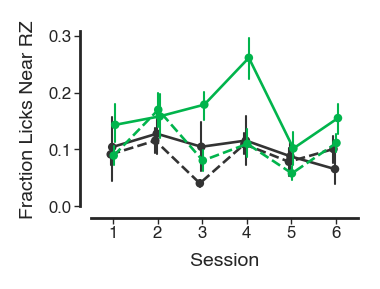

In [226]:
fig = plt.figure(figsize=(2, 1.5), dpi=200)
ax = fig.add_subplot(111)

color = sns.xkcd_palette(['shamrock'])

sns.pointplot(x='session', hue='opsin_condition', y='value', data=grp_df, ax=ax, dodge=True,
             marker='o', scale=0.35, err_style='bars', ci=68, lw=2, palette=['0.2', '0.2', color[0], color[0]],
             errwidth=0.75, linestyles=['--', '-', '--', '-'], hue_order=['Ctrl_0', 'Ctrl_1', 'Arch_0', 'Arch_1'])

clean(ax, offset=4)

# tick_labels = ['RZ1\n (Day 1)', 'RZ1 Cue RZ2\n (Day 2)', 'RZ2\n (Day 2)', 'RZ2\n (Day 3)']
tick_labels = ['1', '2', '3', '4', '5', '6']
ax.set_xticklabels(tick_labels)
ax.set_xlabel('Session')
ax.set_ylabel('Fraction Licks Near RZ')

ax.set_yticks([0, 0.1, 0.2, 0.3])

plt.tight_layout()
ax.get_legend().remove()

fig.savefig(save_dir + 'licks_near_RZ_total.svg', bbox_inches='tight')

In [508]:
for sess in range(1, 7):
    sub_df = grp_df.loc[grp_df['session'] == sess].dropna(subset=['value'])
    md = smf.mixedlm('value ~ C(condition) + C(opsin) + C(condition)*C(opsin)', sub_df, groups=sub_df['mouse'])
    print md.fit().summary()
    print '-----------'

/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         value  
No. Observations:         84              Method:                     REML   
No. Groups:               16              Scale:                      0.0207 
Min. group size:          3               Likelihood:                 35.5038
Max. group size:          6               Converged:                  Yes    
Mean group size:          5.2                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.089    0.031  2.899 0.004  0.029  0.150
C(condition)[T.1]                   0.054    0.043  1.258 0.208 -0.030  0.138
C(opsin)[T.Ctrl]                    0.002    0.043  0.051 0.959 -0.081  0.086
C(cond

/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarni

                    Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         value  
No. Observations:         87              Method:                     REML   
No. Groups:               16              Scale:                      0.0203 
Min. group size:          3               Likelihood:                 32.9698
Max. group size:          6               Converged:                  No     
Mean group size:          5.4                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.170    0.036  4.669 0.000  0.099  0.241
C(condition)[T.1]                  -0.012    0.041 -0.282 0.778 -0.092  0.069
C(opsin)[T.Ctrl]                   -0.054    0.051 -1.054 0.292 -0.155  0.047
C(cond

/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarni

                    Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         value  
No. Observations:         87              Method:                     REML   
No. Groups:               16              Scale:                      0.0176 
Min. group size:          3               Likelihood:                 39.4788
Max. group size:          6               Converged:                  No     
Mean group size:          5.4                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.110    0.033  3.330 0.001  0.045  0.175
C(condition)[T.1]                   0.151    0.038  3.948 0.000  0.076  0.226
C(opsin)[T.Ctrl]                   -0.001    0.047 -0.012 0.990 -0.092  0.091
C(cond

/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sebi/.local/lib/python2.7/site-packages/statsmodels-0.9.0-py2.7-linux-x86_64.egg/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sebi/.

## Relative Licking

In [25]:
# Subtract each session's performance by that on same session of first condition
blocks = []
for _, block in grp_df.groupby(['belt', 'mouse', 'session']):
    
    try:
        baseline_value = block.loc[block['condition'] == 0]['value'].values[0]
        post_value = block.loc[block['condition'] == 1]['value'].values[0]
    except IndexError:
        continue
    else:
        
        diff_value = post_value - baseline_value
        if np.isnan(diff_value):
            continue
        
        block['diff_value'] = post_value - baseline_value
        blocks.append(block)

diff_df = pd.concat(blocks).sort_index()

/home/sebi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
def RZ(row):
    if row['session'] <= 2:
        return 1
    elif row['session'] <=4:
        return 2
    else:
        return 3

diff_df['rz'] = diff_df.apply(RZ, axis=1)

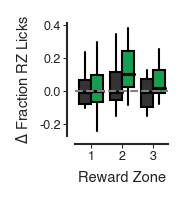

In [503]:
fig = plt.figure(figsize=(0.8, 1), dpi=150)
ax = fig.add_subplot(111)

plot_df = diff_df.loc[diff_df['condition'] == 1]

sns.boxplot(y='diff_value', x='rz', hue='opsin', data=plot_df, ax=ax,
            whis=[5, 95], showcaps=False, showfliers=False, palette=['0.2', color[0]], order=[1, 2, 3], hue_order=['Ctrl', 'Arch'],
            whiskerprops={'linewidth':1})
plt.setp(ax.artists, edgecolor='k', linewidth=1)
plt.setp(ax.lines, color='k')
clean(ax, offset=4)

ax.get_legend().remove()
ax.set_ylabel(r'$\Delta$ Fraction RZ Licks')
ax.set_xlabel('Reward Zone')
# ax.set_xticklabels(['Pre-LED', 'Post-LED'])

ax.axhline(0, color='0.5', ls='--', zorder=1000, lw=1)

fig.savefig(save_dir + 'grouped_rz_diff_box.svg', bbox_inches='tight')

In [31]:
a = plot_df.loc[(plot_df['rz'] == 1) & (plot_df['opsin'] == 'Ctrl')].dropna(subset=['diff_value'])
b = plot_df.loc[(plot_df['rz'] == 1) & (plot_df['opsin'] == 'Arch')].dropna(subset=['diff_value'])
c = plot_df.loc[(plot_df['rz'] == 2) & (plot_df['opsin'] == 'Ctrl')].dropna(subset=['diff_value'])
d = plot_df.loc[(plot_df['rz'] == 2) & (plot_df['opsin'] == 'Arch')].dropna(subset=['diff_value'])
e = plot_df.loc[(plot_df['rz'] == 3) & (plot_df['opsin'] == 'Ctrl')].dropna(subset=['diff_value'])
f = plot_df.loc[(plot_df['rz'] == 3) & (plot_df['opsin'] == 'Arch')].dropna(subset=['diff_value'])

for x in [a, b, c, d, e, f]:
    print ttest_1samp(x['diff_value'], 0)

Ttest_1sampResult(statistic=0.9735657685675067, pvalue=0.33832346881563824)
Ttest_1sampResult(statistic=0.958063867213588, pvalue=0.34326554614849414)
Ttest_1sampResult(statistic=1.5265610763269823, pvalue=0.13770412181465516)
Ttest_1sampResult(statistic=4.921813829885436, pvalue=1.0952304442662992e-05)
Ttest_1sampResult(statistic=-0.5811551205650382, pvalue=0.5667880344172196)
Ttest_1sampResult(statistic=2.5809049315750423, pvalue=0.013530479313866273)


## Mean Learning Curves

0
3
1
4
2
5


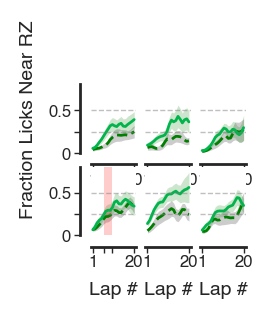

In [507]:
fig = plt.figure(figsize=(1, 1), dpi=200)

n_laps=20
T = range(n_laps)
    
n_sessions = 6
n_conditions = 2

means = np.zeros((n_conditions, n_sessions, n_laps))
sems = np.zeros(means.shape)

n_rows = 2
n_cols = 3

opsins = ['Ctrl', 'Arch']

for session in xrange(1, n_sessions+1):
    
    sub_df = df.loc[(df['session'] == session) & (df['opsin'] == 'Arch') & (0 < df['lapNum']) & (df['lapNum'] <= n_laps)]
#     sub_df = df.loc[(df['session'] == session) & (df['condition'] == 1) & (0 < df['lapNum']) & (df['lapNum'] <= n_laps)]

    for condition in xrange(2):
        cond_df = sub_df.loc[sub_df['condition'] == condition]
#         cond_df = sub_df.loc[sub_df['opsin'] == opsins[condition]]

        cond_mean = cond_df.groupby(['lapNum'])['value'].mean()
        cond_sem = cond_df.groupby(['lapNum'])['value'].sem()
    
        means[condition, session-1, :] = cond_mean
        sems[condition, session-1, :] = cond_sem
        
means = gaussian_filter1d(means, 1, axis=-1)
sems = gaussian_filter1d(sems, 1, axis=-1)

for i in xrange(1, n_sessions+1):
    
    idx = np.unravel_index(i-1, (n_rows, n_cols), order='F')
    idx = np.ravel_multi_index(idx, (n_rows, n_cols), order='C')
    print idx
    
    ax = fig.add_subplot(n_rows, n_cols, idx+1)
    
    ax.plot(T, means[0, i-1, :], 'g', lw=1, ls='--')
    ax.fill_between(T, means[0, i-1, :] - sems[0, i-1, :], means[0, i-1, :] + sems[0, i-1, :], color='k', alpha=0.2, lw=0)
    
    ax.plot(T, means[1, i-1, :], color=color[0], lw=1)
    ax.fill_between(T, means[1, i-1, :] - sems[1, i-1, :], means[1, i-1, :] + sems[1, i-1, :], color='g', alpha=0.2, lw=0)
    
    ax.set_ylim([0, 0.8])
    clean(ax)
    
    if i in [2, 4, 6]:
        ax.set_xlabel('Lap #')
    ax.legend().set_visible(False)
    
    ax.axhline(0.25, color='0.5', alpha=0.5, lw=0.5, ls='--')
    ax.axhline(0.5, color='0.5', alpha=0.5, lw=0.5, ls='--')

    
    if i == 1:
        ax.set_ylabel('Fraction Licks Near RZ')
        sns.despine(left=False, ax=ax, offset=4)
        ax.set_yticks([0, 0.25, 0.5])
        ax.set_yticklabels(['0', '', '0.5'])
    elif i == 2:
        sns.despine(left=False, ax=ax, offset=4)
        ax.set_yticks([0, 0.25, 0.5])
        ax.set_yticklabels(['0', '', '0.5'])
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
        sns.despine(left=True, ax=ax, offset=4)
    
    if i == 2:
        ax.axvspan(5, 9, color='r', alpha=0.2, lw=0)
        ax.set_xticks([0, 5, 9, 19])
#         ax.set_xticklabels(['1', '6', '10', '20'])
        ax.set_xticklabels(['1', '', '', '20'])
    else:
        ax.set_xticks([0, 19])
        ax.set_xticklabels(['1', '20'])

    
# plt.tight_layout()
fig.savefig(save_dir + 'fraction_licks_per_lap.svg')

## Full Lick Raster

In [263]:
def get_anticipatory_licks(bd, abspos, n_laps=20, exclude_reward_duration=10):
    
    laps = abspos.astype(int)
    licks = bd['licking']
    
    for i in xrange(1, n_laps+1):

        numExcPoints = np.int(np.float(
            exclude_reward_duration) / bd["samplingInterval"])
        try:
            firstWater = np.where((laps==i) & bd["water"])[0]
            if(firstWater.size > 0):
                firstWater = firstWater[0]
                licks[firstWater+1:firstWater +
                          numExcPoints] = 0
        except KeyError:
            pass
    
    return licks

In [322]:
arch_expts = [x for x in expts if x.opsin == 'Arch']

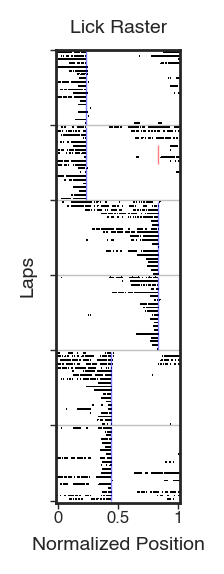

In [495]:
## Lick raster?
fig = plt.figure(figsize=(0.8, 3), dpi=200)
ax = fig.add_subplot(111)

expt_subset = arch_expts[-198:-192]

def calc_raster(expt, n_bins=100, n_laps=20, spacing=1, start_lap=1):

    bd = expt.behaviorData(
        imageSync=False, sampling_interval="actual")

    abspos = ba.absolutePosition(expt.find('trial'), imageSync=False, sampling_interval="actual")
    pos = ((abspos % 1) * n_bins).astype(int) # relative position rounded to two decimals
    laps = abspos.astype(int)

    n_lap_display = n_laps
    spacing = spacing + 1

    raster = np.zeros((n_lap_display*spacing, n_bins))
    
    licking = get_anticipatory_licks(bd, abspos)

#     lick_idx = np.where(bd['licking'])[0]
    lick_idx = np.where(licking)[0]
    for lick_i in lick_idx:
        lap = laps[lick_i]
        if lap < start_lap:
            continue
        elif (lap - start_lap) >= n_laps:
            break
        lick_pos = pos[lick_i]
        raster[(lap-start_lap)*spacing, lick_pos] += 1
        
    return raster
        
rasters = np.vstack([calc_raster(expt) for expt in expt_subset])
    
sns.heatmap(rasters, vmax=1, cmap='Greys', cbar=False)

# clean(ax)
ax.set_xlim([int(-.01*n_bins), int(1.01 * n_bins)])
ax.set_xticks([0, int(n_bins/2), n_bins-1])
ax.set_xticklabels([0, 0.5, 1], rotation=0)
# ax.set_yticks([0 +0.5, n_lap_display * spacing - 2 + 0.5])
ax.set_yticks([(n_lap_display * spacing * ei) - 1 for ei in xrange(len(expt_subset) + 1)])
ax.set_yticklabels([])
# ax.set_yticklabels([1, n_lap_display], rotation=0)
# ax.set_ylim([-0.5, n_lap_display * spacing -0.5])
# ax.set_ylim([n_lap_display * spacing -0.5, -0.5])

# ax.axvline(expt.rewardPositions(units='normalized')[0] * n_bins, color='b', lw=1, alpha=0.5)

for ei, expt in enumerate(expt_subset):
    ax.axhline(n_lap_display*spacing*ei - 1, color='0.5', alpha=0.5, lw=0.5)
    ax.vlines(expt.rewardPositions(units='normalized')[0] * n_bins,
             n_lap_display*spacing*ei, n_lap_display*spacing*(ei+1) - 1, color='b', lw=0.5, alpha=0.5)
    
    if ei == 1:
        ax.vlines(expt_subset[2].rewardPositions(units='normalized')[0] * n_bins,
                    (n_lap_display*ei + 5)*spacing, (n_lap_display*ei + 10)*spacing, color='r', lw=0.5, alpha=0.5)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
ax.set_title('Lick Raster')
ax.set_xlabel('Normalized Position')
ax.set_ylabel('Laps')

fig.savefig(save_dir + 'example_raster.svg')

## Fraction of licks near RZ2

In [259]:
df = ra.fractionLicksNearRZ2PerLap(expts, anticipStartCM=-5, anticipEndCM=5, compareStartCM=-97,
        compareEndCM=97, fractionColName="value",
        exclude_reward=True, exclude_reward_duration=10.0)

In [426]:
df.to_pickle(data_dir + 'fraction_licks_rz2.pkl')

In [478]:
df = pd.read_pickle(data_dir + 'fraction_licks_rz2.pkl')

In [479]:
grp_df = df.groupby(['trial', 'belt', 'mouse', 'opsin', 'condition', 'session'], as_index=False).sum()
grp_df['value'] = grp_df['anticipLicks'] / grp_df['compareLicks']
def opsin_condition(row):
    return row['opsin'] + '_' + str(row['condition'])

grp_df['opsin_condition'] = grp_df.apply(opsin_condition, axis=1)

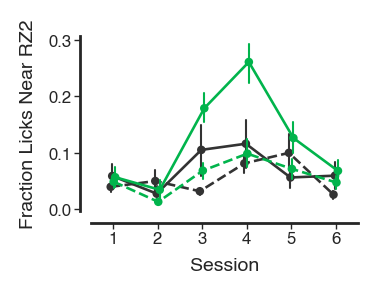

In [428]:
fig = plt.figure(figsize=(2, 1.5), dpi=200)
ax = fig.add_subplot(111)

color = sns.xkcd_palette(['shamrock'])

sns.pointplot(x='session', hue='opsin_condition', y='value', data=grp_df, ax=ax, dodge=True,
             marker='o', scale=0.35, err_style='bars', ci=68, lw=2, palette=['0.2', '0.2', color[0], color[0]],
             errwidth=0.75, linestyles=['--', '-', '--', '-'], hue_order=['Ctrl_0', 'Ctrl_1', 'Arch_0', 'Arch_1'])

clean(ax, offset=4)

# tick_labels = ['RZ1\n (Day 1)', 'RZ1 Cue RZ2\n (Day 2)', 'RZ2\n (Day 2)', 'RZ2\n (Day 3)']
tick_labels = ['1', '2', '3', '4', '5', '6']
ax.set_xticklabels(tick_labels)
ax.set_xlabel('Session')
ax.set_ylabel('Fraction Licks Near RZ2')

ax.set_yticks([0, 0.1, 0.2, 0.3])

plt.tight_layout()
ax.get_legend().remove()

# fig.savefig(save_dir + 'licks_near_RZ_total.svg', bbox_inches='tight')

In [485]:
a = grp_df.loc[grp_df['session'] == 2]
a['rz'] = 1

b = rz2_df.loc[rz2_df['session'] == 2]
b['rz'] = 2

df = pd.concat([a, b])

/home/sebi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sebi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


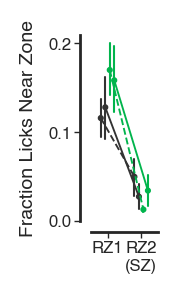

In [496]:
fig = plt.figure(figsize=(1, 1.5), dpi=200)
ax = fig.add_subplot(111)

color = sns.xkcd_palette(['shamrock'])

sns.pointplot(x='rz', hue='opsin_condition', y='value', data=df, ax=ax, dodge=0.4,
             marker='o', scale=0.25, err_style='bars', ci=68, lw=1, palette=['0.2', '0.2', color[0], color[0]],
             errwidth=0.75, linestyles=['--', '-', '--', '-'], hue_order=['Ctrl_0', 'Ctrl_1', 'Arch_0', 'Arch_1'])

clean(ax, offset=4)

# tick_labels = ['RZ1\n (Day 1)', 'RZ1 Cue RZ2\n (Day 2)', 'RZ2\n (Day 2)', 'RZ2\n (Day 3)']
tick_labels = ['RZ1', 'RZ2\n(SZ)']
ax.set_xticklabels(tick_labels)
ax.set_xlabel('')
ax.set_ylabel('Fraction Licks Near Zone')
# ax.set_title('Session 2\n(Post-Stim)')

ax.set_yticks([0, 0.1, 0.2])

plt.tight_layout()
ax.get_legend().remove()

fig.savefig(save_dir + 'rz1_rz2_comparison.svg')